<a href="https://colab.research.google.com/github/marcinwolter/MachineLearning2020_projects/blob/main/Klaudia_Misio%C5%82ek_data_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Badam zachowania społeczne myszy w testach behawioralnych. Dane, których użyłam, są wynikami z całej puli eksperymentów w których przeprowadzam test preferencji miejsca warunkowanej kontekstem społecznym.

Procedura składa się z trzech faz: pretestu, warunkowania oraz posttestu. Pretest trwa 30 minut i polega na umieszczeniu zwierzęcia w klatce złożonej z dwóch przedziałów różniących się rodzajem ściółki i dodatkowych elementów wzbogacających środowisko (tu będą to drewniane gryzaki). Zwierzę może swobodnie eksplorować klatkę. Mierzony jest czas spędzany przez zwierzę w każdym z przedziałów. Warunkowanie polega na przenoszeniu zwierząt co 24 godziny (przez maksymalnie 10 dni) pomiędzy klatkami zawierającymi jeden z dwóch poznanych w preteście kontekstów. W jednym z nich myszy będą przebywały w grupie (kontekst społeczny), w drugim samotnie (kontekst izolacji). Posttest wygląda tak samo jak prestest. Poruszanie się zwierzęcia po klatce rejestrowane będzie za pomocą kamery. Miarą nagradzających właściwości kontekstu skojarzonego z przebywaniem w grupie jest zmiana preferencji przedziału z pretestu na posttest. 

Kolumny age pretest / age posttest - to wiek myszy (w dniach) odpowiednio w fazie pretestu i posttestu.

Kolumny weight pretest / weight posttest - to waga myszy (w dniach) odpowiednio w fazie pretestu i posttestu.

Kolumny Pretest. Distance moved / Posttest. Distance moved m  -  to dystans (w metrach) jaki mysz przebyła odpowiednio w fazie pretestu i posttestu. 

Kolumny Pretest. Velocity / Posttest. Velocity  - to średnia prędkość (w cm/s) z jaką mysz się poruszała odpowiednio w fazie pretestu i posttestu.

Kolumna Social context - to kolumna określająca, który z zaprojektowanych dwóch kontekstów został wykorzystany jako ten, na którym wszystkie myszy spędzały czas w grupie (kontekst społeczny), były to ściółka bukowa (zakodowana jako 0) lub ściółka celulozowa (zakodowana jako 1)

Kolumny Pretest. Time spent in isolate context % /  Posttest. Time spent in isolate context % - to procent czasu jaki mysz spędziła na kontekście izolacji odpowiednio w fazie pretestu i posttestu. 

Kolumny Pretest. Time spent in social context % /  Posttest. Time spent in social context % - to procent czasu jaki mysz spędziła na kontekście społecznym odpowiednio w fazie pretestu i posttestu.


Ten ostatni parametr jest dla mnie najistotniejszy - pozwala mi określić jak bardzo dla danej myszy kontekst społeczny jest nagradzający - jak bardzo woli spędzać czas z innymi myszami niż spędzać czas samotnie w izolacji. Większość myszy woli spędzać czas na kontekście społecznym - są to zwierzęta, które z natury spędzają czas w grupach. Niektóre z parametrów są wyraźnie ze sobą skorelowane np wiek i waga - wraz z wzrostem wieku, rośnie waga. Naszym najnowszym odkryciem jest to, że w wieku (38-39 dni posttest) myszy nagle wolą spędzać czas na kontekście izolacji. Przed oraz po tym okresie, myszy wolą spędzać czas na kontekście społecznym. Byłam ciekawa czy analiza PCA pozwoli mi zauważyć, które z parametrów wykorzystywanych przeze mnie do analizy zachowania myszy są najistotniejsze - którymi mogę się głównie kierować.

1. W pierwszym kroku zrobiłam macierz korelacji, aby mieć pogląd na dane.
2. W kolejnym kroku przeprowadziłam PCA, aby sprawdzić jak prezentuje się rozkład składowych głównych w moich danych.
3. Kiedy okazało się, że pierwsze 3 komponenty wyjaśniają >86% wariancji, postanowiłam zrobić heatmapę, która pozwoli mi zrozumieć, które z parametrów są najbardziej skorelowane z daną składową główną.
4. Następnie wykonałam wykres 2D (tylko z dwoma komponentami, które tłumaczą >67% wariancji) i jako kolor punktów wybrałam wiek w posttescie - widać, że wyodrębniają się grupy.
5. W kolejnym kroku wykonałam wizualizację 3D trzech składowych głównych, jednak wynik ten pozostaje dla mnie trudny do interpretacji.
6. W ostatnim etapie mojego projektu chciałam spróbować przewidzieć "Posttest time in social context %" na podstawie moich własnych danych.
7. Podzieliłam swoje dane i przetestowałam kilka modeli regresji, aby wykorzystać ten o największym wskaźniku validation score.
8. Wybrałam HuberRegressor. Następnie chciałam sprawdzić dokładność modelu w moim zbiorze walidacyjnym, więc dopasowałam ten model do całego zbioru danych treningowych. Porównałam prognozy z oczekiwanymi wynikami w zbiorze walidacyjnym.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error


url = 'https://github.com/KlaudiaMisiolek/My_data_project/blob/main/data.xlsx?raw=true'

In [ ]:
# Introduction of the data. This is my actual data from behavioral experiments with mice. 
# In the pretest and test I measure time mice spent on social context bedding (beech or cellulose). 
# Pretest is performed to observe mice basal preference to any of the contexts. 
# Test is performed to observe the change in preference to any of the contexts after a few days of conditioning (to social and isolate context).

experiment_data = pd.read_excel(url)
experiment_data.head()
# 0 - social context beech, 1 - social context cellulose

,Age\npretest,Age\nposttest,Weight pretest,Weight posttest,Pretest. Distance moved m,Pretest. Velocity cm/s,Pretest. Time spent in social context %,Pretest. Time spent in isolate context %,Posttest.Distance moved m,Posttest. Velocity cm/s,Posttest. Time spent in social context %,Posttest. Time spent in isolate context %,Social context
0,24,31,7.8,11.3,45.0142,2.52154,44.831289,54.996157,48.4497,2.69647,62.774432,37,0
1,26,33,14.3,17.5,49.8834,2.79885,40.835306,59.069947,56.5995,3.14777,58.232510,42,1
2,26,33,11.4,16.0,59.7594,3.32572,47.227803,52.527861,50.4937,2.80788,68.798120,31,1
3,26,33,8.2,15.0,50.7834,2.83250,42.186394,57.602310,49.4046,2.74778,67.053850,33,1
4,27,34,11.2,16.7,47.5465,2.64415,56.216045,43.717406,68.1903,3.79176,43.556311,56,0


In [ ]:
# The correlation matrix between each feature. 
# I performed it to have greater ability to interpret the data.
# Some of them are inversally correlated, eg. "Posttest. Time spent in isolate context" and "Posttest. Time spent in social context" because they are mutually exclusive.

corr = experiment_data.corr()
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(3)

,Age pretest,Age posttest,Weight pretest,Weight posttest,Pretest. Distance moved m,Pretest. Velocity cm/s,Pretest. Time spent in social context %,Pretest. Time spent in isolate context %,Posttest.Distance moved m,Posttest. Velocity cm/s,Posttest. Time spent in social context %,Posttest. Time spent in isolate context %,Social context
Age pretest,1.000,1.000,0.687,0.482,0.311,0.310,0.188,-0.186,0.275,0.275,-0.033,0.030,-0.204
Age posttest,1.000,1.000,0.687,0.482,0.311,0.310,0.188,-0.186,0.275,0.275,-0.033,0.030,-0.204
Weight pretest,0.687,0.687,1.000,0.749,0.307,0.304,0.020,-0.021,0.212,0.214,0.017,-0.008,-0.129
Weight posttest,0.482,0.482,0.749,1.000,0.336,0.334,0.091,-0.092,0.170,0.174,-0.030,0.034,-0.144
Pretest. Distance moved m,0.311,0.311,0.307,0.336,1.000,0.999,0.052,-0.052,0.576,0.575,-0.199,0.178,-0.141
Pretest. Velocity cm/s,0.310,0.310,0.304,0.334,0.999,1.000,0.049,-0.048,0.576,0.575,-0.201,0.179,-0.135
Pretest. Time spent in social context %,0.188,0.188,0.020,0.091,0.052,0.049,1.000,-1.000,0.068,0.066,0.056,-0.077,-0.351
Pretest. Time spent in isolate context %,-0.186,-0.186,-0.021,-0.092,-0.052,-0.048,-1.000,1.000,-0.068,-0.066,-0.054,0.075,0.350
Posttest.Distance moved m,0.275,0.275,0.212,0.170,0.576,0.576,0.068,-0.068,1.000,1.000,-0.305,0.284,-0.029
Posttest. Velocity cm/s,0.275,0.275,0.214,0.174,0.575,0.575,0.066,-0.066,1.000,1.000,-0.306,0.285,-0.027


PCA components:   [0.3754483  0.29590522 0.19767078 0.0814294  0.03690555 0.00884568]


<BarContainer object of 6 artists>

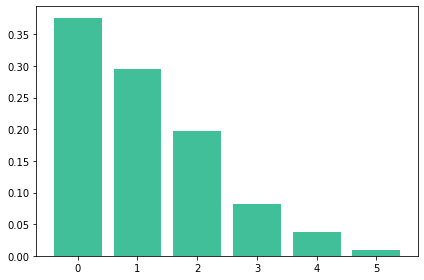

In [ ]:
# The principal component analysis.
# The first two components explain >67% of variation. The first three components explain >86% of variation.
# 0 - PCA Component 1, 1 - PCA Component 2, 2 - PCA Component 3 etc.

pca = decomposition.PCA(n_components=6)
pc = pca.fit_transform(experiment_data)

principal_ratio = pca.explained_variance_ratio_
print("PCA components:  ",pca.explained_variance_ratio_)

fig, ax = plt.subplots(tight_layout=True)
ax.bar( [x for x in range(principal_ratio.size )], principal_ratio, color=(.25, .75, .6, 1))

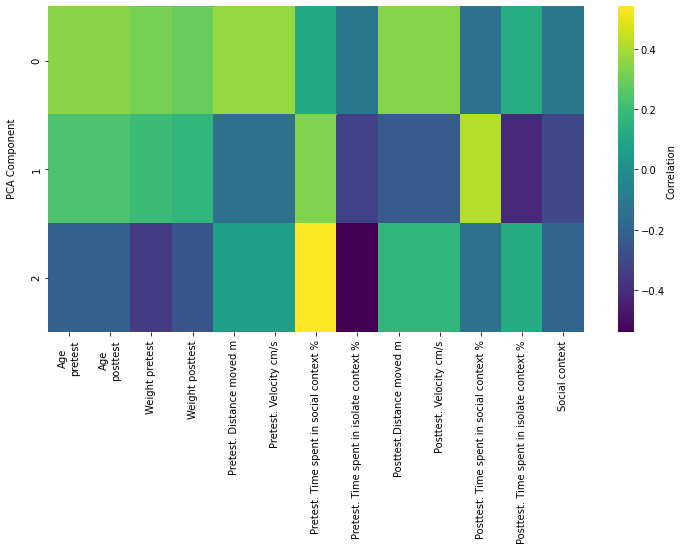

In [ ]:
# This heatmap and the color bar represent the correlation between the various features and the principal components themselves.
# 0 - PCA Component 1, 1 - PCA Component 2, 2 - PCA Component 3 

scaler = preprocessing.StandardScaler()
scaler.fit(experiment_data)
scaled_data = scaler.transform(experiment_data)

pca = decomposition.PCA(n_components=3)
pca.fit(scaled_data)

map = pd.DataFrame(pca.components_, columns=experiment_data.keys())
plt.figure(figsize=(12,6))
plt.text(-1, 1.75, 'PCA Component', rotation=90)
plt.text(15, 1.75, 'Correlation', rotation=90)
sns.heatmap(map,cmap='viridis')

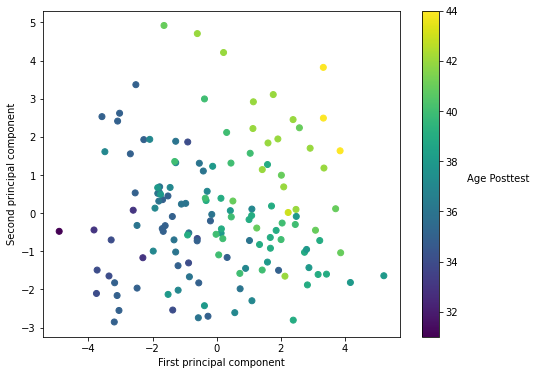

In [ ]:
# The 2D visualisation of the first and second PCA component.
# I used a color gradient to distinguish between different age (in days) of mice in posttest (the test after conditioning).


pca = decomposition.PCA(n_components=2)
pca.fit(scaled_data)

x_pca = pca.transform(scaled_data)

plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0], x_pca[:,1], c=experiment_data.iloc[:, 1], cmap='viridis')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

clb = plt.colorbar()
clb.set_label('Age Posttest', rotation=0, labelpad=40)

(139, 3)


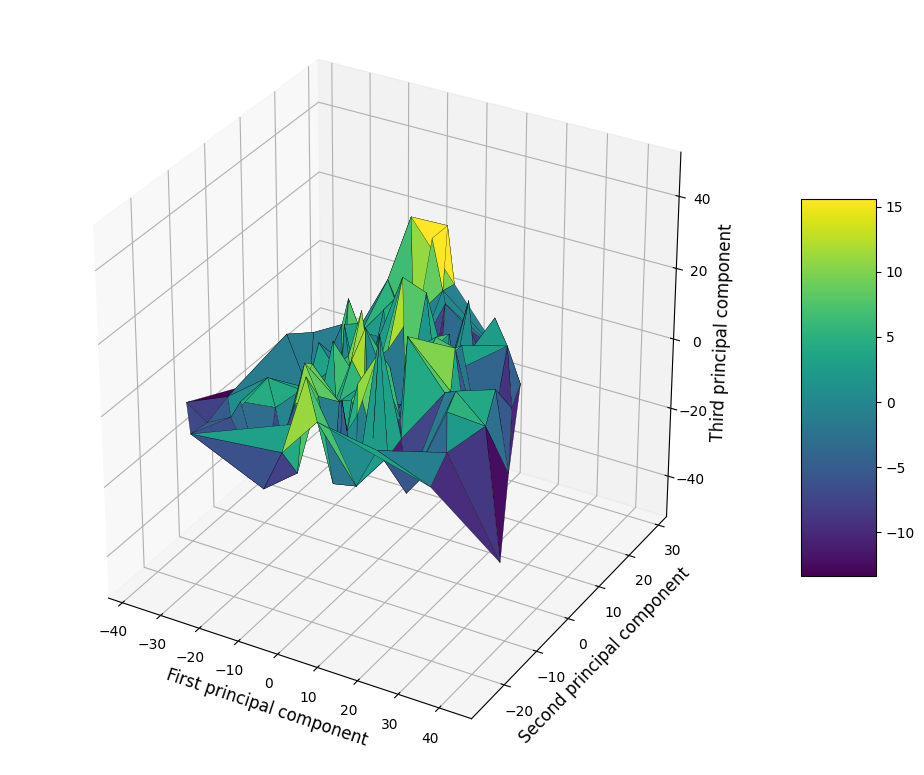

In [ ]:
# The 3D visualization of the first three principal components.

pca = decomposition.PCA(n_components=3)
td_pca = pca.fit_transform(experiment_data)
print(td_pca.shape)
x = td_pca[:, 0]
y = td_pca[:, 1]
z = td_pca[:, 2]
plt.figure(figsize=(12, 10), dpi=100)
ax = plt.axes(projection='3d')

surf = ax.plot_trisurf(x, y, z, cmap='viridis', edgecolor='black', linewidth=0.2, antialiased=True)
ax.set_xlabel('First principal component', fontsize=12, rotation=-10)
ax.set_ylabel('Second principal component', fontsize=12, rotation=40)
ax.set_zlabel('Third principal component', fontsize=12)
ax.set_zlim(-50, 50)

plt.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


In [ ]:
# At last, I wanted to check whether the data I already have can be used to predict the "Posttest. Time spent in social context %" because it seems yo be the most important feature of the experiments.
# At first I loaded my data (the same as used before) and created a dataframe.
# Then I split the data it in two parts - 50% of which was used to train, evaluate and select among regression models (KNeighborsRegressor, HuberRegressor, LinearRegression, AdaBoostRegressor), and 50% used as a validation dataset.
# At the end I compared the algorythms.
# I have chosen the HuberRegressor with the best validation score among others.

names = ['Age\npretest',	'Age\nposttest',	'Weight pretest',	'Weight posttest',	'Pretest. Distance moved m',	'Pretest. Velocity cm/s',	'Pretest. Time spent in social context %',	'Pretest. Time spent in isolate context %',	'Posttest.Distance moved m',	'Posttest. Velocity cm/s',	'Posttest. Time spent in social context %',	'Posttest. Time spent in isolate context %',	'Social context']
dataset = pd.read_excel(url, names=names)


array = dataset.values
X = array[:, 0:13]
X = np.delete(X,[10,11],1)
y = array[:, 10]

X_scaled = preprocessing.StandardScaler().fit_transform(X)
y_scaled = y/np.max(y)

X_train, X_validation, Y_train, Y_validation = train_test_split(X_scaled, y_scaled, test_size=.5, random_state=3, shuffle=True)

# model = KNeighborsRegressor(n_neighbors=5)
# Training score:  0.18472047039313266
# Validation score:  0.028121562343034867

# model = HuberRegressor(max_iter=500)
# Training score:  0.15095642388204955
# Validation score:  0.019860410225906122

# model = LinearRegression()
# Training score:  0.1705108862173369
# Validation score:  0.07998585195323793

model = AdaBoostRegressor(n_estimators=500)
# Training score:  0.759904862615757
# Validation score:  0.0848018053471361

model.fit(X_train, Y_train)

print("Training score: ",model.score(X_train, Y_train))
print("Validation score: ",model.score(X_validation, Y_validation))

Training score:  0.759904862615757
Validation score:  0.0848018053471361


Validation mean_squared_error =  0.011560687684628526
Training   mean_squared_error =  0.002592240551644442


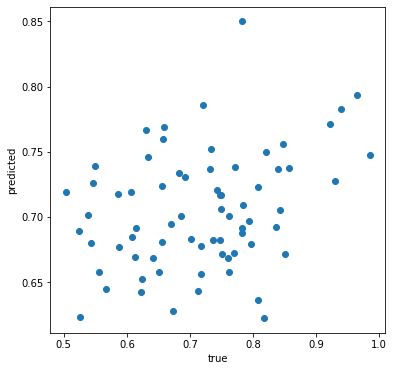

In [ ]:
# Then I wanted to check the accuracy of the model on my validation set so I fitted the model on the entire training dataset.
# I compared predictions by comparing them to the expected results in the validation set.

predictions = model.predict(X_validation)
predictions_train=model.predict(X_train)
# Evaluate predictions
print("Validation mean_squared_error = ",mean_squared_error(Y_validation, predictions))
print("Training   mean_squared_error = ",mean_squared_error(Y_train, predictions_train))

# plot fitted vs expected
plt.figure(figsize=(6,6))
plt.scatter(Y_validation,predictions)
plt.xlabel("true")
plt.ylabel("predicted")
plt.show()